# MoCo-v2: Linear Probing - STL-10 + ResNet-50 CNN encoder

#### Single GPU Training

In [1]:
import pickle, os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

from stl10_train_dataset import get_stl10_train_test_data
from movov2_architecture_multigpu import MoCo, resnet50_stl10

In [2]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

torch version: 2.0.1+cu117
Number of GPU(s) available = 8
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3090
Available device is cuda


#### Load DDP saved model

having ```module``` in it!

[refer](https://stackoverflow.com/questions/70386800/what-is-the-proper-way-to-checkpoint-during-training-when-using-distributed-data)

In [3]:
saved_model = torch.load("mocov2_stl10_best_trainloss.pth")

In [4]:
from collections import OrderedDict

new_state_dict = OrderedDict()

for k, v in saved_model.items():
    name = k[7:]
    new_state_dict[name] = v

In [5]:
# Initialize MoCo instance-
moco = MoCo(
    # rank = rank,
    embed_dim = 128, K = 65536,
    m = 0.999, T = 0.2
)

moco.load_state_dict(new_state_dict)

<All keys matched successfully>

In [ ]:
# Initialize a new ResNet-50 CNN encoder (query encoder)-
model = resnet50_stl10(embed_dim = 128)

In [ ]:
# Load pre-trained query encoder params-
model.load_state_dict(moco.encoder_query.state_dict())

In [8]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=2048, bias=False)
  (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=2048, out_features=128, bias=True)
)

In [9]:
# Remove projection head and add linear classifier-
model.fc = nn.Linear(in_features = 2048, out_features = 10, bias = True)

In [10]:
# Initialize dense layer-
model.fc.weight.data.normal_(mean = 0.0, std = 0.01)
model.fc.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
# Sanity check-
model.fc

Linear(in_features=2048, out_features=10, bias=True)

In [12]:
del moco

In [13]:
# Save pre-trained MoCo-v2 ResNet-50 CNN query encoder-
torch.save(model.state_dict(), "MoCov2_ResNet50_pretrained_query_encoder.pth")

In [5]:
# Initialize a new ResNet-50 CNN encoder (query encoder)-
model = resnet50_stl10(embed_dim = 128)

In [6]:
# Remove projection head and add linear classifier-
model.fc = nn.Linear(in_features = 2048, out_features = 10, bias = True)

In [7]:
# Initialize dense layer-
model.fc.weight.data.normal_(mean = 0.0, std = 0.01)
model.fc.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
model.load_state_dict(torch.load("MoCov2_ResNet50_pretrained_query_encoder.pth"))

<All keys matched successfully>

In [9]:
# Freeze all layers except linear output layer-
for name, param in model.named_parameters():
    if name not in ["fc.weight", "fc.bias"]:
        param.requires_grad = False

In [29]:
# Sanity checks-
model.layer1[0].conv1.weight.requires_grad

False

In [30]:
model.conv1.weight.requires_grad

False

In [31]:
model.layer4[2].conv2.weight.requires_grad

False

In [33]:
model.fc.weight.requires_grad

True

In [10]:
def count_trainable_params(model):
    # Count number of layer-wise parameters and total parameters-
    tot_params = 0
    for param in model.parameters():
        # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
        tot_params += param.nelement()

    return tot_params

print(f"ResNet-50 CNN has {count_trainable_params(model)} params")

ResNet-50 CNN has 23520842 params


In [11]:
# Move o GPU-
model = model.to(device)

In [12]:
model.conv1.weight.size()

torch.Size([64, 3, 3, 3])

In [13]:
model.conv1.weight[0]

tensor([[[-0.0104,  0.0309,  0.0765],
         [ 0.0375,  0.1092, -0.1079],
         [-0.1745, -0.1690, -0.0713]],

        [[-0.0756,  0.0314, -0.1087],
         [-0.0799,  0.0844,  0.0901],
         [ 0.0130,  0.0384,  0.0684]],

        [[-0.1145,  0.1433, -0.1626],
         [ 0.0164, -0.0487,  0.1872],
         [ 0.0933, -0.0349,  0.1369]]], device='cuda:0')

In [ ]:
model.conv1.weight[0]

In [14]:
model.layer1[0].conv3.weight.size()

torch.Size([256, 64, 1, 1])

In [15]:
model.layer1[0].conv3.weight[0, :3, :, :]

tensor([[[ 0.0188]],

        [[-0.0330]],

        [[ 0.0241]]], device='cuda:0')

In [ ]:
model.layer1[0].conv3.weight[0, :3, :, :]

In [16]:
model.layer4[2].conv2.weight.size()

torch.Size([512, 512, 3, 3])

In [17]:
model.layer4[2].conv2.weight[10, 100, :, :]

tensor([[-0.0067,  0.0115, -0.0038],
        [ 0.0073,  0.0115,  0.0009],
        [-0.0148,  0.0261,  0.0006]], device='cuda:0')

In [ ]:
model.layer4[2].conv2.weight[10, 100, :, :]

In [19]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# Only train linear (output) layer-
optimizer = torch.optim.SGD(
    params = model.fc.parameters(), lr = 30.0,
    momentum = 0.9, weight_decay = 0
)

In [ ]:
class CosineScheduler:
    def __init__(
        self, max_update,
        base_lr = 0.01, final_lr = 0,
        warmup_steps = 0, warmup_begin_lr = 0
    ):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps


    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase


    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + np.cos(
                np.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr


In [ ]:
'''
# Cosine lr scheduler-
# decay until 90th epoch
# 10 linear lr warmup epochs
scheduler = CosineScheduler(
    max_update = 90, base_lr = 30,
    final_lr = 0.03, warmup_steps = 10,
    warmup_begin_lr = 0.0001
)
'''

In [ ]:
'''
lr_vals = [scheduler(epoch = epoch) for epoch in range(1, num_epochs + 1)]

plt.figure(figsize = (12, 10))
plt.plot(list(range(1, 101)), lr_vals)
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("Linear Probing - LR scheduler")
plt.show()
'''

### Learning Rate scheduler

As mentioned by authors in their official repo.

__linear step-decays (by 1/10) at $60^{th}$ and $70^{th}$ epochs__.

[refer](https://github.com/facebookresearch/moco/blob/main/main_lincls.py)

In [20]:
step_decay_scheduler = [60, 80]

In [21]:
def adjust_learning_rate(optimizer, epoch, args):
    """Decay the learning rate based on schedule"""
    # lr = args.lr
    lr = 30.0
    for milestone in args:
        lr *= 0.1 if epoch >= milestone else 1.0
        
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


In [22]:
batch_size = 64
num_epochs = 100

### STL-10 dataset - train & test

In [23]:
# Get STL-10 train and test (supervised classification) datasets-
train_loader, test_loader, train_dataset, test_dataset = get_stl10_train_test_data(
    path_dataset = '/home/majumdar/Downloads/.data/',
    batch_size = batch_size
)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
def train_model_progress(model, train_loader, train_dataset):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()


def test_model_progress(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()



In [25]:
# Python3 dict to contain training metrics-
train_history = {}

# Initialize parameters saving 'best' models-
best_test_acc = 50

In [ ]:
for epoch in range(1, num_epochs + 1):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    
    test_loss, test_acc = test_model_progress(
        model = model, test_loader = test_loader,
        test_dataset = test_dataset
    )
    
    curr_lr = optimizer.param_groups[0]['lr']

    # Adjust step-decay LR scheduler-
    adjust_learning_rate(
        optimizer = optimizer, epoch = epoch,
        args = step_decay_scheduler
    )

    # Cosine LR scheduler-
    # optimizer.param_groups[0]['lr'] = scheduler(epoch = epoch)
    
    print(f"\nepoch: {epoch} train loss = {train_loss:.4f}, "
          f"train accuracy = {train_acc:.2f}%, test loss = {test_loss:.4f}"
          f", test accuracy = {test_acc:.2f}% & "
          f"LR = {curr_lr:.7f}\n")
    
    train_history[epoch] = {
        'loss': train_loss, 'acc': train_acc,
        'test_loss': test_loss, 'test_acc': test_acc,
        'lr': curr_lr
    }


    # Save best weights achieved until now-
    if (test_acc > best_test_acc):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_test_acc = test_acc

        print(f"Saving model with highest test acc = {test_acc:.4f}%\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "MoCov2_ResNet50_LinearProbe_STL10_best_testacc.pth")
        

In [27]:
# Save training metrics as Python3 history for later analysis-
with open("MoCov2_LinearProbe_ResNet50_train_history.pkl", "wb") as file:
    pickle.dump(train_history, file)
del file

In [31]:
del model

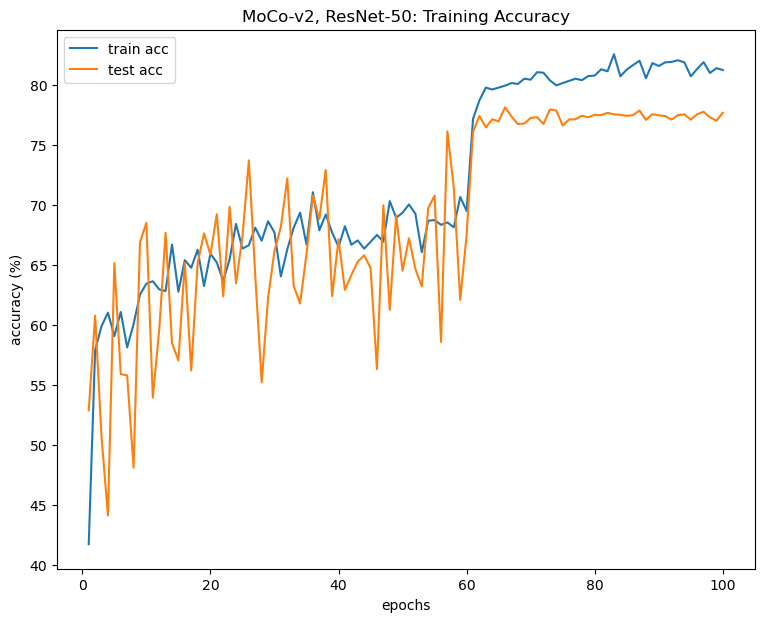

In [28]:
plt.figure(figsize = (9, 7))
plt.plot(list(train_history.keys()), [train_history[k]['acc'] for k in train_history.keys()], label = 'train acc')
plt.plot(list(train_history.keys()), [train_history[k]['test_acc'] for k in train_history.keys()], label = 'test acc')
plt.title("MoCo-v2, ResNet-50: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

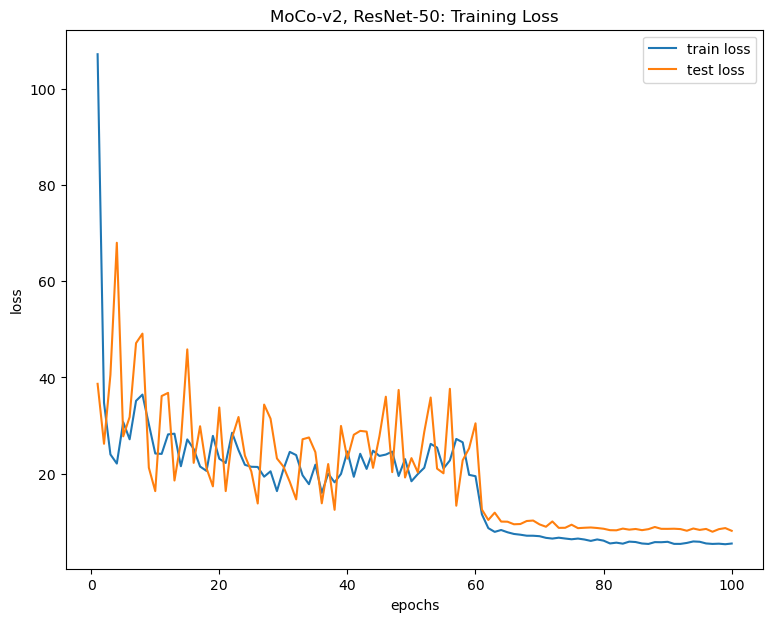

In [29]:
plt.figure(figsize = (9, 7))
plt.plot(list(train_history.keys()), [train_history[k]['loss'] for k in train_history.keys()], label = 'train loss')
plt.plot(list(train_history.keys()), [train_history[k]['test_loss'] for k in train_history.keys()], label = 'test loss')
plt.title("MoCo-v2, ResNet-50: Training Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.show()

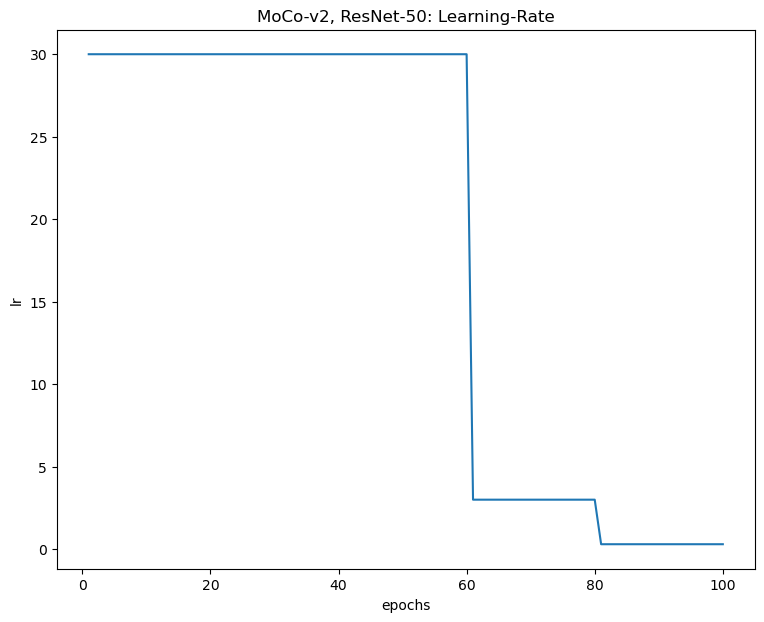

In [30]:
plt.figure(figsize = (9, 7))
plt.plot(list(train_history.keys()), [train_history[k]['lr'] for k in train_history.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("MoCo-v2, ResNet-50: Learning-Rate")
plt.show()

In [ ]:
# Initialize and load 'best' trained parameters from above-
best_model = resnet50_stl10(embed_dim = 128)

# Remove projection head and add linear classifier-
best_model.fc = nn.Linear(in_features = 2048, out_features = 10, bias = True)

# Load trained params-
best_model.load_state_dict(torch.load("MoCov2_ResNet50_LinearProbe_STL10_best_testacc.pth"))

# Move to GPU device-
best_model.to(device)

In [35]:
# Get validation metrics of 'best' trained model-
test_loss, test_acc = test_model_progress(
    model = best_model, test_loader = test_loader,
    test_dataset = test_dataset
)

print("ResNet-50 'best' trained testing metrics: ",
      f"loss = {test_loss:.4f} & acc = {test_acc:.2f}%"
)

Validation: : 100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:17<00:00,  7.14batch/s, val_acc=78.1, val_loss=9.46]

ResNet-50 'best' trained testing metrics:  loss = 9.4630 & acc = 78.14%
